# A toy Example
In this example we'll try to learn a generator sampling from a simple multivariate Gaussian.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

# vegans imports:
from vegans import MMGAN, WGAN, WGANGP
from vegans.utils import plot_losses, plot_image_samples

ngpus = 0

Text(0.5, 1.0, 'Sample cov matrix from multivariate Gaussian')

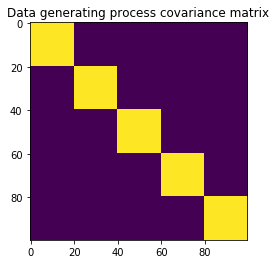

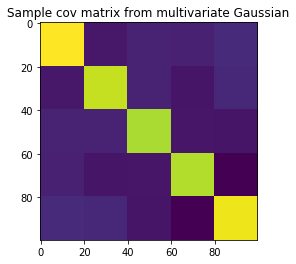

In [67]:
""" tests
"""
N = 100
cov_mat = 0.3 * np.ones((N,N))

# define 10 ranges:
for i in range(5):
    cov_mat[i*20:(i+1)*20,i*20:(i+1)*20] = 0.7

plt.imshow(cov_mat)
plt.title('Data generating process covariance matrix')

# sample. TODO: also retrieve non-trivial mean?
samples = np.random.multivariate_normal(mean=np.array([0. for _ in range(N)]), cov=cov_mat, size=1000)

# re-cover matrix
cov_mat_recovered = np.cov(samples.T)

plt.figure()
plt.imshow(cov_mat_recovered)
plt.title('Sample cov matrix from multivariate Gaussian')

In [52]:
nz = 5
N = 100

In [41]:
class GaussianDataset(Dataset):
    def __init__(self, mu=0., stdev=1, N=2, len_=10000):
        self.mu = np.array([mu for _ in range(N)])
        self.stdev = stdev
        self.N = N
        self.len_ = len_

    def __getitem__(self, idx):
        # return np.random.normal(loc=self.mu, scale=self.stdev, size=(self.N,)).astype(np.float32), 0
        return np.random.multivariate_normal(mean=self.mu, cov=cov_mat).astype(np.float32), 0

    def __len__(self):
        return self.len_

In [42]:
dataset = GaussianDataset(N=N)
dataloader = DataLoader(dataset, batch_size=16)

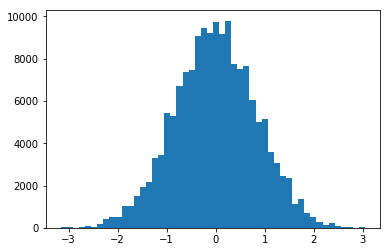

In [43]:
""" Look at our (flattened) data distribution
"""
vals = []
for _ in range(100):
    vals += list(next(iter(dataloader))[0].flatten())
plt.hist(vals, bins=50);

In [74]:
""" Define a critic
"""
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(N, 50)
        self.bn1 = nn.BatchNorm1d(num_features=50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        # x = torch.sigmoid(x)
        return x
    
""" Define a generator
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(nz, 30)
        self.bn1 = nn.BatchNorm1d(num_features=30)
        self.fc2 = nn.Linear(30, N)

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        # x = torch.tanh(self.fc2(x))
        return x

In [84]:
def plot_generator_cov(generator_):
    """ Try the generator on a noise mini-batch and compute sample covariance matrix
    """
    z = torch.from_numpy(np.random.randn(10000, nz).astype(np.float32))
    samples = generator_(z)
    cov_mat_est = np.cov(samples.detach().numpy().T)

    plt.imshow(cov_mat_est)

In [90]:
""" Create those networks
"""
critic = Critic()
generator = Generator()

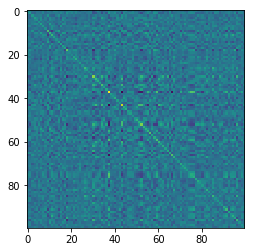

In [85]:
""" What's the covariance before training?
"""
plot_generator_cov(generator)

In [95]:
optimizer_D = optim.RMSprop(critic.parameters(), lr=10)
optimizer_G = optim.RMSprop(generator.parameters(), lr=10)

gan = WGAN(generator, critic, dataloader, ngpu=ngpus, nr_epochs=20, nz=nz, print_every=200, optimizer_D=optimizer_D, optimizer_G=optimizer_G)

device: cpu


In [96]:
gan.train(clip_value=1);

[0/20][200/625](- iter/s)	Loss_D: -0.000	Loss_G: -0.099
[0/20][400/625](58.819 iter/s)	Loss_D: 0.000	Loss_G: -0.099
[0/20][600/625](58.501 iter/s)	Loss_D: 0.000	Loss_G: -0.099
[1/20][175/625](59.422 iter/s)	Loss_D: -0.000	Loss_G: -0.099
[1/20][375/625](45.931 iter/s)	Loss_D: 0.000	Loss_G: -0.099
[1/20][575/625](44.416 iter/s)	Loss_D: -0.000	Loss_G: -0.099
[2/20][150/625](55.553 iter/s)	Loss_D: -0.000	Loss_G: -0.099
[2/20][350/625](53.606 iter/s)	Loss_D: -0.000	Loss_G: -0.099
[2/20][550/625](38.227 iter/s)	Loss_D: 0.000	Loss_G: -0.099
[3/20][125/625](32.077 iter/s)	Loss_D: 0.000	Loss_G: -0.099
[3/20][325/625](49.595 iter/s)	Loss_D: -0.000	Loss_G: -0.099
[3/20][525/625](43.563 iter/s)	Loss_D: 0.000	Loss_G: -0.099
[4/20][100/625](33.994 iter/s)	Loss_D: 0.000	Loss_G: -0.099
[4/20][300/625](40.430 iter/s)	Loss_D: 0.000	Loss_G: -0.099
[4/20][500/625](47.987 iter/s)	Loss_D: 0.000	Loss_G: -0.099
[5/20][75/625](49.238 iter/s)	Loss_D: -0.000	Loss_G: -0.099
[5/20][275/625](41.635 iter/s)	Loss_D: 

In [97]:
samples_l, D_losses, G_losses = gan.get_training_results()

(array([6.000e+00, 5.000e+00, 1.000e+00, 8.000e+00, 8.000e+00, 6.000e+00,
        6.000e+00, 8.000e+00, 3.000e+00, 5.000e+00, 7.000e+00, 1.400e+01,
        5.000e+00, 9.000e+00, 1.600e+01, 2.600e+01, 2.500e+01, 2.000e+01,
        4.100e+01, 8.200e+01, 7.800e+01, 1.090e+02, 9.400e+01, 1.240e+02,
        2.880e+02, 8.430e+02, 1.057e+03, 9.970e+02, 5.560e+02, 5.850e+02,
        4.770e+02, 2.120e+02, 2.130e+02, 1.690e+02, 1.190e+02, 8.500e+01,
        3.600e+01, 4.600e+01, 4.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([-43214.793 , -41633.184 , -40051.58  , -38469.97  , -36888.36  ,
        -35306.754 , -33725.145 , -32143.537 , -30561.93  , -28980.32  ,
        -27398.713 , -25817.105 , -24235.498 , -22653.889 , -21072.281 ,
        -19490.674 , -17909.066 , -16327.457 , -14745.85  , -13164.241 ,
        -11582.634 , -10001.025 ,  -8419.418 ,  -6837.8096,  -5256.2017,
         -3

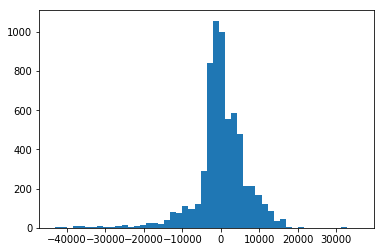

In [98]:
plt.hist(list(samples_l.items())[-1][1].detach().numpy().flatten(), bins=50)

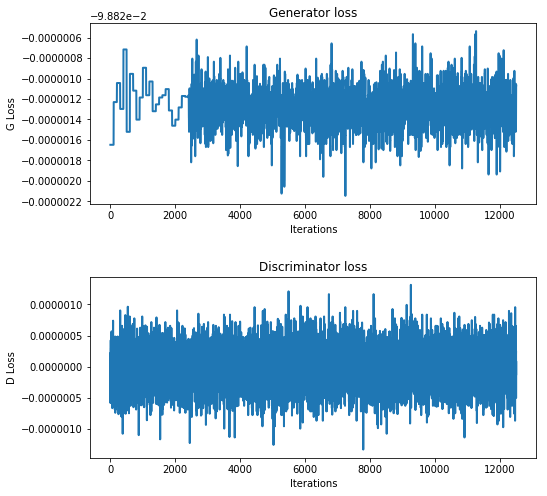

In [99]:
plot_losses(G_losses, D_losses)

In [100]:
# TODO: show how covariance matrix evolves over training

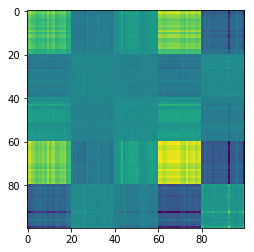

In [101]:
plot_generator_cov(generator)